# Optimization

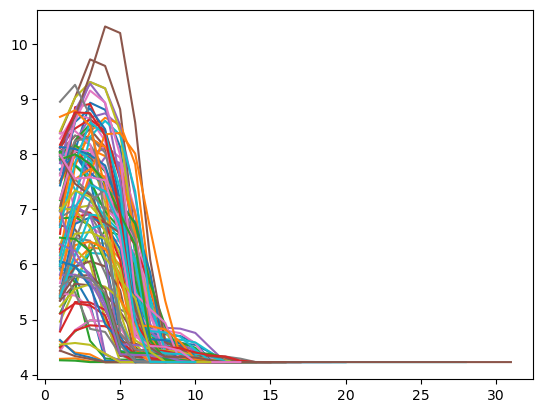

True
optimal design variable:
   capture_width       8.176 [m]
   pen_diameter       17.949 [m]
   pen_height          5.494 [m]
   spacing           122.762 [m]
   stock_density      30.000 [kg/m^3]
   pen_depth          22.903 [m]
----------------------------------------
optimal objective function terms:
   cost_per_yield      4.228 [$/kg]
   price          2697779.560 [$]
   fish_yield     638093.557 [kg]
----------------------------------------
optimal constraints:
   P_gen_cons               -0.000 [kWh]
   fish_yield_cons       24107.869 [kg]
   env_Umin_cons             0.190 [m/s]
   env_Umax_cons             1.800 [m/s]
   env_tempmin_cons         14.000 [C]
   env_tempmax_cons         12.000 [C]
   env_salinitymin_cons      3.000 [PSU]
   env_salinitymax_cons      2.000 [PSU]
   env_O2_min_cons           3.590 [mg/l]
----------------------------------------


In [1]:
import modules
import optimization
import numpy as np
import importlib
importlib.reload(modules)
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter

max_iter = 10000

def print_bold(str):
    print('\033[1m' + str + '\033[0;0m')
    return

def print_objective(x0, x_name, p):
    cost_per_yield, price, fish_yield = modules.obj_terms(x0, x_name, p)
    print(' '*2, "cost_per_yield", "{:10.3f}".format(cost_per_yield), '[$/kg]')
    print(' '*2, "price         ", "{:10.3f}".format(price), '[$]')
    print(' '*2, "fish_yield    ", "{:10.3f}".format(fish_yield), '[kg]')

def print_ineq_cons(x0, x_name, p):
    print(' '*2, "P_gen_cons          ", "{:10.3f}".format(modules.ineq_constraint(x0, x_name, p)[0]), '[kWh]')
    print(' '*2, "fish_yield_cons     ", "{:10.3f}".format(modules.ineq_constraint(x0, x_name, p)[1]), '[kg]')
    print(' '*2, "env_Umin_cons       ", "{:10.3f}".format(modules.ineq_constraint(x0, x_name, p)[2]), '[m/s]')
    print(' '*2, "env_Umax_cons       ", "{:10.3f}".format(modules.ineq_constraint(x0, x_name, p)[3]), '[m/s]')
    print(' '*2, "env_tempmin_cons    ", "{:10.3f}".format(modules.ineq_constraint(x0, x_name, p)[4]), '[C]')
    print(' '*2, "env_tempmax_cons    ", "{:10.3f}".format(modules.ineq_constraint(x0, x_name, p)[5]), '[C]')
    print(' '*2, "env_salinitymin_cons", "{:10.3f}".format(modules.ineq_constraint(x0, x_name, p)[6]), '[PSU]')
    print(' '*2, "env_salinitymax_cons", "{:10.3f}".format(modules.ineq_constraint(x0, x_name, p)[7]), '[PSU]')
    print(' '*2, "env_O2_min_cons     ", "{:10.3f}".format(modules.ineq_constraint(x0, x_name, p)[8]), '[mg/l]')
            
def optimize_result(x_name, x_list, x_unit, res, p, opt_idx):
    col_width = len(max(x_list, key=len))
    print(res[opt_idx].success)
    print_bold("optimal design variable:")
    for i in range(len(x_list)):
        print(' '*2, x_list[i], ' '*(col_width - len(x_list[i])) , "{:10.3f}".format(res[opt_idx].x[i]), x_unit[i])
    print("-"*40)

    print_bold("optimal objective function terms:")
    print_objective(res[opt_idx].x, x_name, p)
    print("-"*40)
    
    print_bold("optimal constraints:")
    print_ineq_cons(res[opt_idx].x, x_name, p)
    print("-"*40)
    
    
# fill default parameters
all_vars = ['x_wec','x_type_wec','x_pen','p_pen','x_env','p_wec','p_fish_salmon']

wec_types = ['point absorber'] #,'attenuator','terminator','point absorber']

# design variables
x_name = ['x_wec','x_pen']
x_list, x0_val, x_unit, x_bnds, x_label = optimization.default_value(x_name)
x0 = []
for i in range(len(x_list)):
    x0.append(x0_val[x_list[i]])

# parameters
param_name = ['x_type_wec']
param_val = {}


#optimization
best_idx = 0
res={}

fig, ax = plt.subplots(1,1)
opt_res_history = []
cons_history = []
iteration_history = []

for i in range(len(wec_types)):
    param_val['wec_type'] = wec_types[i]
    p_list, p, p_unit, p_bnds, p_label = optimization.argument_fun(x_name, param_name, param_val, all_vars)
    
    iteration = np.linspace(1,max_iter+1,max_iter+1)
    
    for n_test in range(100):
        x0 = []
        for i0 in range(len(x_bnds)):
            x0.append(np.random.uniform(low=x_bnds[i0][0], high=x_bnds[i0][1]))
    
        res[i], op_obj = optimization.run_optimization(x_name, x0, param_name, param_val, all_vars, max_iter)
    

        if res[i].fun < res[best_idx].fun:
            best_idx = i
        
        ax.plot(iteration, op_obj.f)
        
        opt_res_history.append(op_obj.f)
        iteration_history.append(op_obj.count)
        cons_history.append(op_obj.ineq)

plt.show()

optimize_result(x_name, x_list, x_unit, res, p, best_idx)

# Plot fish growth and fish oxygen demand

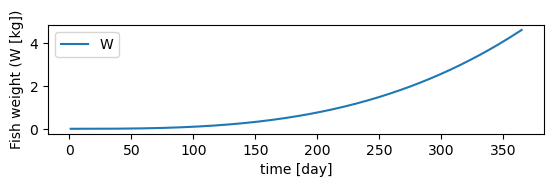

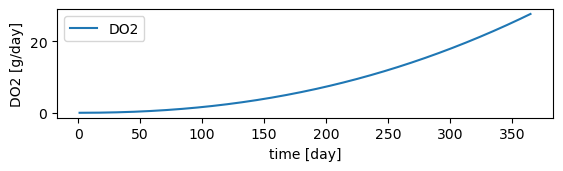

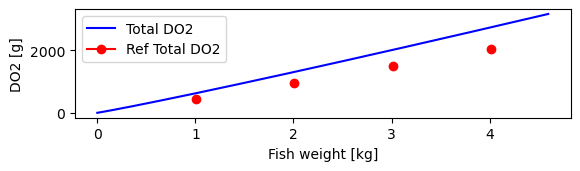

DO2 for 1kg fish 592.658417961274
DO2 for 2kg fish 1267.6196206239329
DO2 for 3kg fish 1968.158657940374
DO2 for 4kg fish 2690.091351663788
fish weight after 365 days 4597.867265255341


In [2]:
x_opt = res[best_idx].x
modules.plot_variable(x_opt, x_name, p)

# Plot objective function and constraints

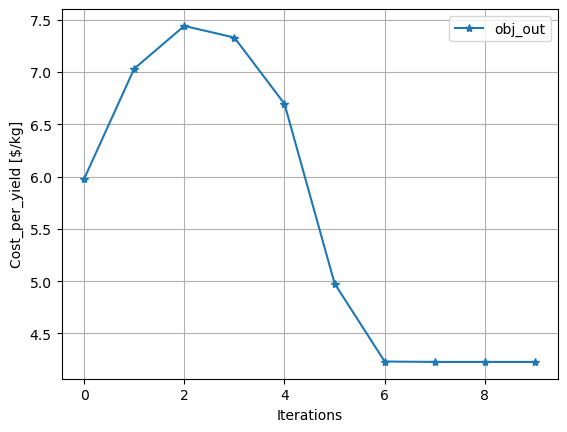

In [3]:
fig, ax = plt.subplots(1,1)
ax.plot(op_obj.f, label='obj_out', marker='*')
ax.set(xlabel='Iterations', ylabel='Cost_per_yield [$/kg]')
ax.legend()
ax.grid(True)
plt.show()

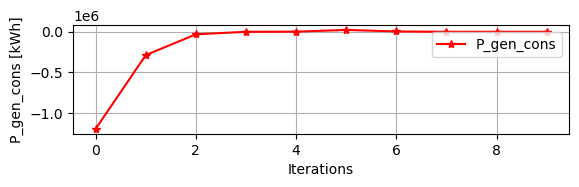

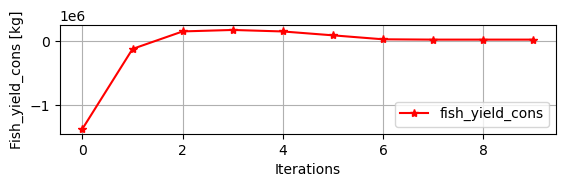

In [4]:
ax1 = plt.subplot(3,1,1)
ax1.plot(op_obj.ineq[:, 0], 'r', label='P_gen_cons', marker='*')
ax1.set(xlabel='Iterations', ylabel='P_gen_cons [kWh]');
ax1.legend()
ax1.grid(True)
plt.show()

ax2 = plt.subplot(3,1,2)
ax2.plot(op_obj.ineq[:, 1], 'r', label='fish_yield_cons', marker='*')
ax2.set(xlabel='Iterations', ylabel='Fish_yield_cons [kg]');
ax2.legend()
ax2.grid(True)
plt.show()
